In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from model import list_entropy, mutual_information
from model import crp
import seaborn as sns
sns.set_context("talk")

# Evaluation of the Prior over reward functions

Here, we are consered with the efficacy of generalization. One way to evaluate the value of generalization is to evalute how well a generalizater "guesses" in a new context. Here, we consider the case when the agent has to guess which "goal" is correct in a new context.


Let $g \in G = \{g_1, g_2, ...\}$ be a discrete goal the agent is trying to guess, and let $c\in \mathcal{C}=\{c_1, c_2, ...\}$ be the context. We will assume that for each new context, the goals are distributed by the exchanagle distribution $p$, such that the probability goal $g$ is selected in the new context $c_{t+1}$ is defined:
$$ p_{g_i} = \Pr(g=g_i | c_{t+1})$$

Our generalizing agent, on the other hand, proposes distribution $q_{g_i} = \Pr(g=g_i|c_{t+1}) $ as its prior over goals in the new context $c_{t+1}$. This prior acts as a guess over goals, and the best possible guess is $q=p$. 

### Information content of the prior
We can evaluate the quality of $q$ as a prior by the degree of surprise for each new goal. Formally, this is the information content of the goal, which is defined as $h$:
$$ h(g|q) = \log_2 \frac{1}{q_g}$$
and its expecation, the entropy of $q$:
$$ \text{H}(q) = \sum_{g} q_g\log_2 \frac{1}{q_g}$$

Lower values of information (surprise) signify a better guess, and the value is minimized when  $p=q$. Consequently, the theoretical lower limit of the surprise is the entropy of the true distribution of goals:
$$ \text{H}(p) = \sum_{g} p_g\log_2 \frac{1}{p_g}$$

For an upper bound, the entropy of a uniform prior, $\text{H}(u) = \sum_{g} \frac{1}{||G||}\log_2 \frac{1}{1/||G||}$ is a reasonable limit.

Consequently, we can say that the agent benefits from generlization if $\text{H}(q) < \text{H}(u)$, and we can expect $\text{H}(q) \geq \text{H}(p)$.

# CRP Generalization improves as a function of structure
In this first example there is a sequence of 5 goals, none of which is repeated. Note the entropy of the Uniform distribution and the true distribution are the same, and there is not benefit to generalization.

Entropy H(Goal):           2.32


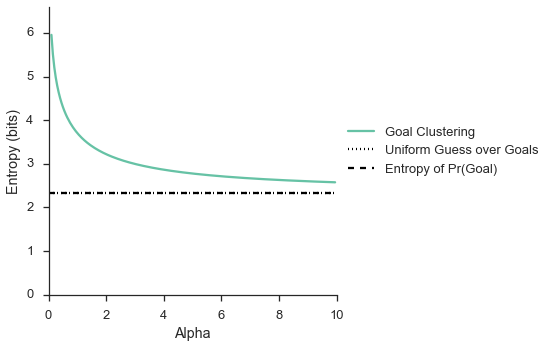

In [2]:
context_goals = [0, 1, 2, 3, 4]
crp.plot_evaluate(context_goals, max_goals=5)

As we add repeats of goals, we can start to see a generalization benefit for the CRP at high values of alpha

Entropy H(Goal):           1.88


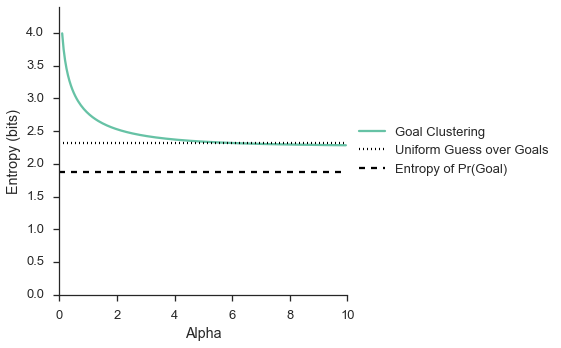

In [3]:
context_goals = [0] * 5 + [1, 2, 3, 4]
crp.plot_evaluate(context_goals, max_goals=5)

With 10 repeats of the first goal, there is a clear generalization benfit

Entropy H(Goal):           1.43


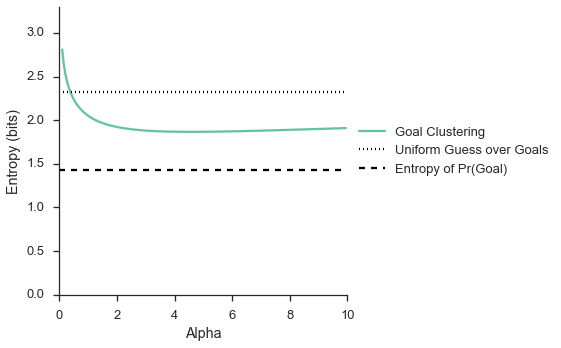

In [4]:
context_goals = [0] * 10 + [1, 2, 3, 4]
crp.plot_evaluate(context_goals, max_goals=5)

We can be more systematic by generating sequences of varying degrees of structure (repeats of the first goal) and comparing the performace of the CRP to the uniform distribution. Here, we'll optimize the value of alpha for each sequence

In [5]:
#minimize the alpha for each goal sequence
from scipy.optimize import minimize

upperbound = np.log2(4)

h_p = list()
generalization_benefit = list()
generalization_benefit_fa = list()
best_alpha = list()
for repeats in range(1, 200):
    context_goals = [0] * repeats + range(1, 4)
    def f0(alpha):
        return crp.evaluate(context_goals, alpha=alpha)
    res = minimize(f0, 0.1)
    
    
    generalization_benefit.append(upperbound-res.fun)
    generalization_benefit_fa.append(upperbound - f0(1.0))
    best_alpha.append(res.x)
    h_p.append(list_entropy(context_goals))

We can see that that if we optimize for alpha, the CRP does no worse for any level of "true" entropy, but that for very stochastic (low entropy) sequences, very high values of alpha are needed.

In contrast, if we use a fixed alpha value for the CRP, we can see that it does worse than the uniform distribution when there is high entropy.

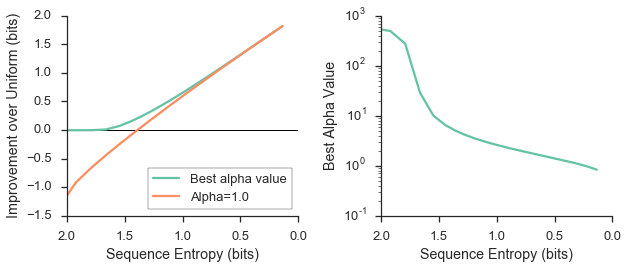

In [6]:
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    axes[0].plot([0, 2], [0, 0],'k-', linewidth=1.0)
    h0 = axes[0].plot(h_p, generalization_benefit, label='Best alpha value')
    h1 = axes[0].plot(h_p, generalization_benefit_fa, label='Alpha=1.0')
    axes[0].set_xlim(2, 0)
    axes[0].set_xlabel('Sequence Entropy (bits)')
    axes[0].set_ylabel('Improvement over Uniform (bits)')
    legend = axes[0].legend(loc='lower right', frameon = 1)
    frame = legend.get_frame()
    frame.set_facecolor('white')

    axes[1].plot(h_p, best_alpha)
    axes[1].set_xlim(2, 0)
    axes[1].set_xlim(2, 0)
    axes[1].set_yscale('log')
    axes[1].set_xlabel('Sequence Entropy (bits)')
    axes[1].set_ylabel('Best Alpha Value')
    plt.subplots_adjust(wspace=0.35)
    plt.tight_layout()
    sns.despine()

Lower value of $\alpha$ mean the model is more likley to generalize old values in new context. So, when there is
more structure in the world, it is more beneficial to generalize.

*Conclussion: The lower the entropy of the goal distribution, the more valuable in general it is to cluster*

# The CRP is an unbiased estimator (asymptotically)

One question we can ask about our generalizaiton model is whether it is a good 
estimate of the true statistics of the world. Specifically, we can ask whether 
it gives an *unbiased* estimate of the underlying statistics. Formally, the bias 
of an estimator $\hat \theta$ is the difference between the expectation of the 
estimate and the true values $\theta$:

$\text{Bias}_\theta[\hat \theta] = \mathop{\mathbb{E}}_\theta \left [\hat \theta \right]-\theta$


We can say that an estimator is an unbiased estimator if and only if $\text{Bias}_\theta[\hat \theta] =0$. If we think of the CRP as an estimator of the unknown probability distribution of future contexts $q=\hat p$, then the CRP is a *baised* estimator of $p$, with its bias equal to the probability it gives to new clusters:

$\text{Bias}_p[q] = \frac{-\alpha}{\alpha + N_c}$

where $N_c$ is the total number of contexts the CRP has encountered. Fortunately, the bias
of the estimator decreases as a function of $N_c$, such that as the number of contexts experienced goes to infinity, $\text{Lim}_{N_c\to \infty}\left [\alpha/(\alpha + N_c)\right ]=0$ and the estimator becomes unbiased.

## Empirical Demonstration
Here, we show that the CRP becomes a better estimator of the underlying distribution as 
$N_c$ increases

model/crp.py:86: RuntimeWarning: invalid value encountered in log2
  goal_guesses -= np.log2(crp_pmf[k])


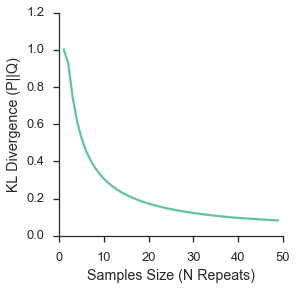

In [7]:
#minimize the alpha for each goal sequence
lowerbound = np.log2(2)

sample_size = list()
generalization_benefit = list()
best_alpha = list()

for repeats in range(1, 50):
    context_goals = [0, 1] * repeats
    
    p = [0.5, 0.5, 0, 0]  # this is the "true" distribution over goals 1-4
    
    def f0(alpha):
        return crp.evaluate(context_goals, alpha=alpha)
    res = minimize(f0, 1.0)
    
    generalization_benefit.append(crp.kl_divergence(context_goals, p, alpha=res.x))
    sample_size.append(repeats)
    
# plot the results
fig = plt.figure(figsize=(4, 4))
plt.subplots_adjust(wspace=0.3)
ax = plt.gca()
ax.plot(sample_size, generalization_benefit)
ax.set_xlabel('Samples Size (N Repeats)')
ax.set_ylabel('KL Divergence (P||Q)')
sns.despine()

## Goal predictions conditional on enviornment models

An agent moving exploring an enviornment will typically gain experience in that enviornment early, whereas it may only recieve rewards later. If this is the case, it may or may not be useful to guess about goal distribuiton using conditional on the envoirnmental experience.

let $p_g$ be the true distributions of goals for context $c_{t+1}$ and let $p_e$ be the true distribution of enviornments for context $c_{t+1}$. If $p_g$ and $p_e$ are known, than the agent is always better using $p_e$ to infer $p_g$. In this case, the lower bound is:

$$\text{H}(g|e) = \text{H}(g) - \text{I}(g|e)$$ 

The mutual information, $\text{I}(g, e)$, is a non-negative quanity that measure the degree of information shared between $g$ and $e$, that is, the degree to which knowledge of one informs knowledge of the other.

## Independent Clustering
Nonetheless, it is not always the case that clustering goals conditionally on enviornments provides a better guess. In the example below, independent clustering strictly dominates clustering goals conditionally overall values of $\alpha$, and both show a generalization benefit wehn $\alpha > 4$.

Notice, the mutual information here is low.

Entropy H(Goal):           1.42
Entropy H(Enviornment):    1.00
Mutual Information I(G,E): 0.00


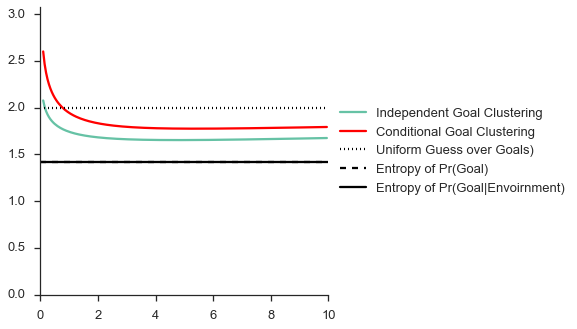

In [8]:
context_goals = [0] * 16 + [1] * 4 + [2] * 2 + [3] * 2
context_maps = [0, 1] * (len(context_goals) / 2)
crp.plot_evaluate_joint(context_goals, context_maps)

If we increase the mutual information between the two sequences, the pattern reverse (note, the performance of indpendent clustering is the same in these cases)

Entropy H(Goal):           1.42
Entropy H(Enviornment):    1.00
Mutual Information I(G,E): 0.46


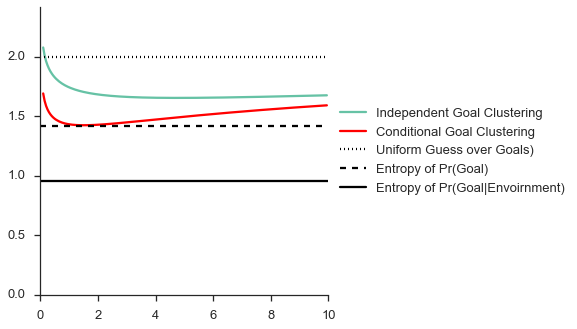

In [9]:
context_goals = [0] * 16 + [1] * 4 + [2] * 2 + [3] * 2
context_maps = [0] * (len(context_goals) / 2) + [1] * (len(context_goals) / 2)
crp.plot_evaluate_joint(context_goals, context_maps)

# systematic attempt at quantifying I

Entropy H(Goal):           1.00
Entropy H(Enviornment):    1.00
Mutual Information I(G,E): 0.53


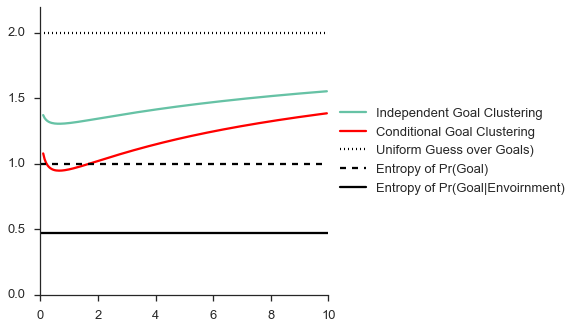

In [10]:
def comp_mi_conflict(N, n):
    context_goals = [0] * N + [1] * N 
    context_maps = [0] * (n) + [1]*(N-n) + [1] * n + [0] *(N-n)
    crp.plot_evaluate_joint(context_goals, context_maps, max_goals=4)
comp_mi_conflict(10, 9)

Entropy H(Goal):           1.00
Entropy H(Enviornment):    1.00
Mutual Information I(G,E): 0.00


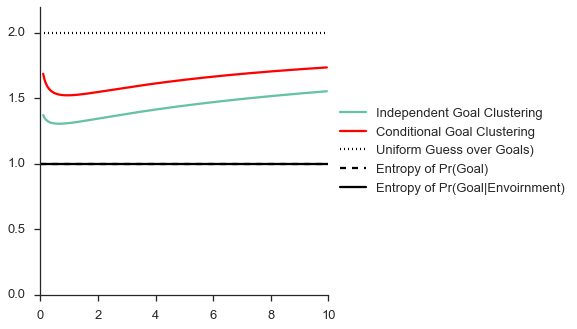

In [11]:
comp_mi_conflict(10, 5)

Entropy H(Goal):           1.00
Entropy H(Enviornment):    1.00
Mutual Information I(G,E): 0.12


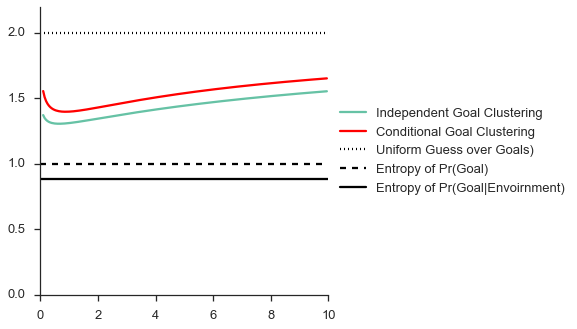

In [12]:
comp_mi_conflict(10, 7)

Entropy H(Goal):           1.00
Entropy H(Enviornment):    1.00
Mutual Information I(G,E): 0.12


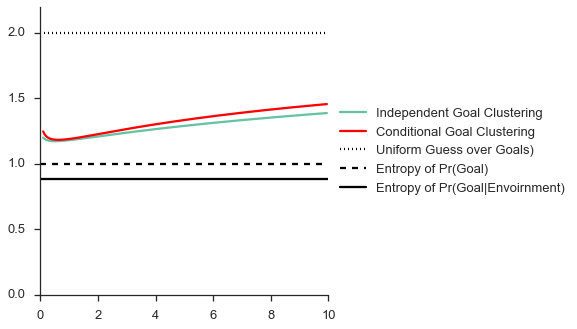

In [13]:
comp_mi_conflict(20, 14)

Entropy H(Goal):           1.82
Entropy H(Enviornment):    1.00
Mutual Information I(G,E): 0.10


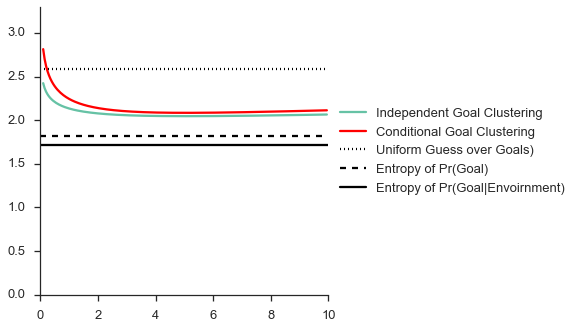

In [14]:
def comp_mi_conflict2(N, n):
    context_goals = [0] * N + [1] * N  + range(2, 6) * 2
    context_maps = [0] * (n) + [1]*(N-n) + [1] * n + [0] *(N-n) + [0]*4 + [1]*4
    crp.plot_evaluate_joint(context_goals, context_maps, max_goals=6)
comp_mi_conflict2(20, 14)

Entropy H(Goal):           1.82
Entropy H(Enviornment):    1.00
Mutual Information I(G,E): 0.01


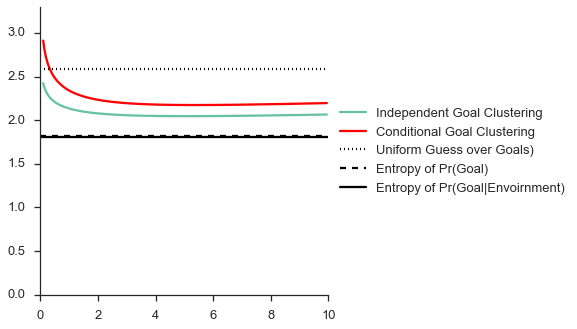

In [15]:
comp_mi_conflict2(20, 11)

Entropy H(Goal):           1.00
Entropy H(Enviornment):    4.32
Mutual Information I(G,E): 1.00


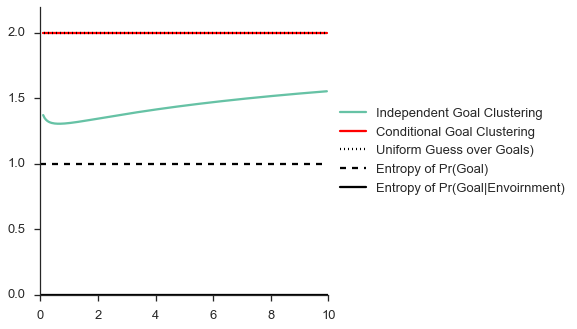

In [16]:
def comp_mi_conflict3(repeats = 1):
    context_goals = ([0] * 10 + [1]*10) * repeats
    context_maps = range(0, 20) * repeats
    crp.plot_evaluate_joint(context_goals, context_maps, max_goals=4)
comp_mi_conflict3(1)

Entropy H(Goal):           1.00
Entropy H(Enviornment):    4.32
Mutual Information I(G,E): 1.00


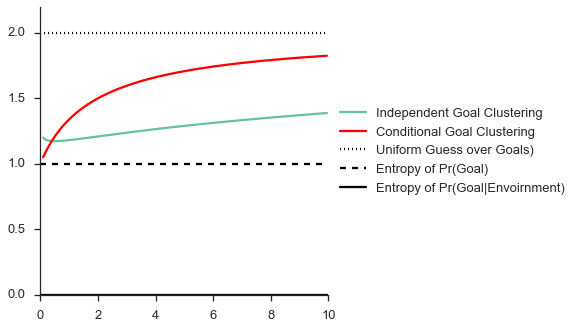

In [17]:
comp_mi_conflict3(2)

Entropy H(Goal):           1.00
Entropy H(Enviornment):    4.32
Mutual Information I(G,E): 1.00


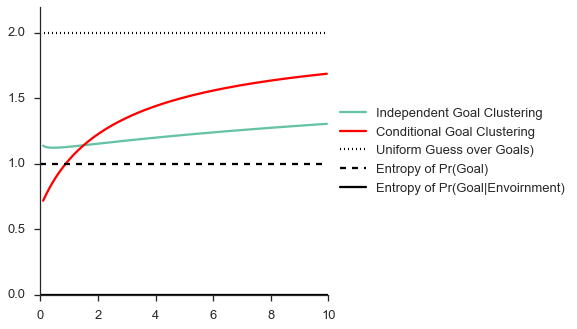

In [18]:
comp_mi_conflict3(3)

Entropy H(Goal):           1.00
Entropy H(Enviornment):    2.52
Mutual Information I(G,E): 0.60


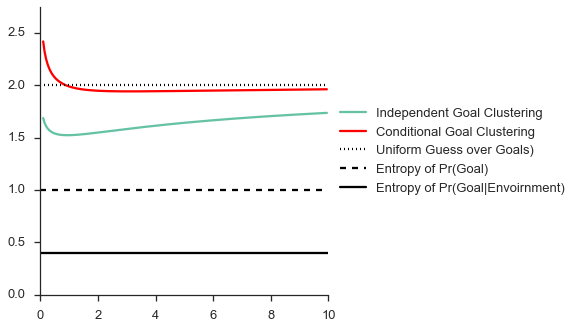

In [19]:
def comp_mi_conflict4(repeats = 1):
    context_goals = ([0] * 5 + [1]*5) * repeats
    context_maps = ([0] * 2 + range(1, 7) + [0] * 2) * repeats
    crp.plot_evaluate_joint(context_goals, context_maps, max_goals=4)
comp_mi_conflict4(1)

Entropy H(Goal):           1.00
Entropy H(Enviornment):    2.52
Mutual Information I(G,E): 0.60


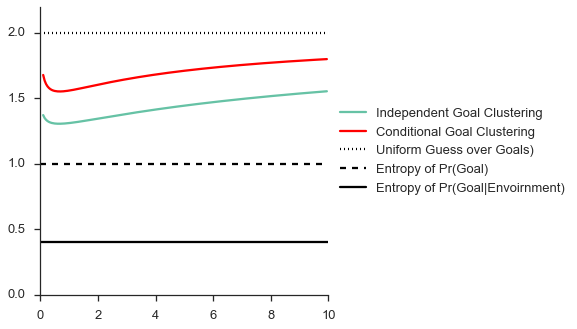

In [20]:
comp_mi_conflict4(2)

Entropy H(Goal):           1.00
Entropy H(Enviornment):    2.52
Mutual Information I(G,E): 0.60


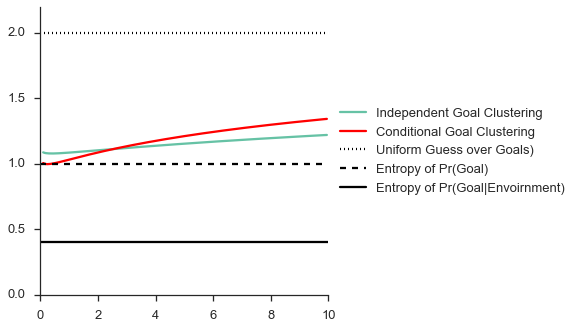

In [21]:
comp_mi_conflict4(10)

Entropy H(Goal):           1.00
Entropy H(Enviornment):    2.52
Mutual Information I(G,E): 0.60


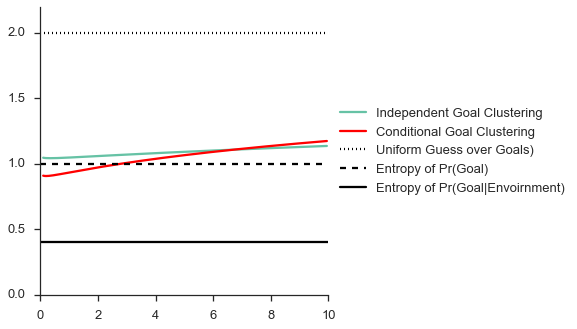

In [22]:
comp_mi_conflict4(20)

Entropy H(Goal):           1.00
Entropy H(Enviornment):    5.32
Mutual Information I(G,E): 1.00


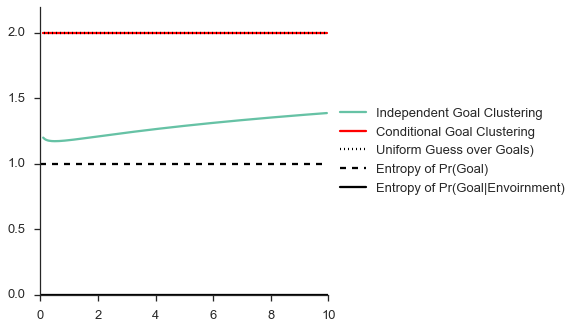

In [23]:
def comp_mi_conflict5(n =1, N=20):
    context_goals = ([0] * N + [1]*N)
    context_maps = [0] * (N-n) + (range(1, n+1)) + [n+1] * (N-n) + (range(n+2, 2*(n+1)))
    crp.plot_evaluate_joint(context_goals, context_maps, max_goals=4)
comp_mi_conflict5(n=19, N=20)

Entropy H(Goal):           1.00
Entropy H(Enviornment):    5.22
Mutual Information I(G,E): 1.00


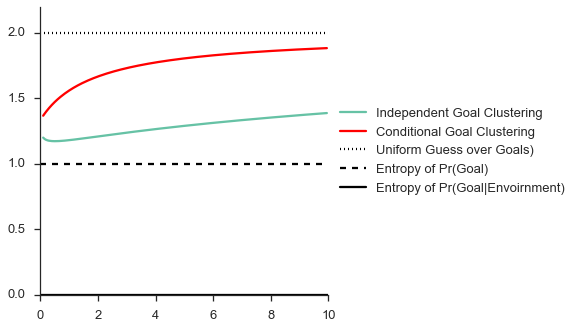

In [24]:
comp_mi_conflict5(n=18, N=20)

Entropy H(Goal):           1.00
Entropy H(Enviornment):    5.08
Mutual Information I(G,E): 1.00


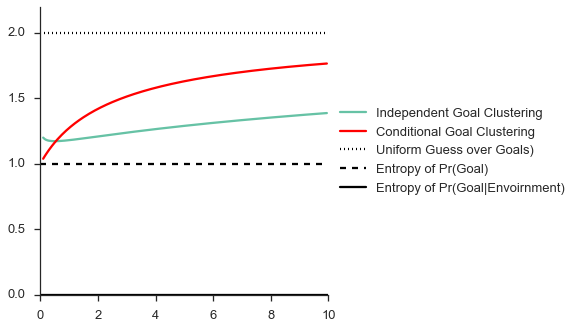

In [25]:
comp_mi_conflict5(n=17, N=20)

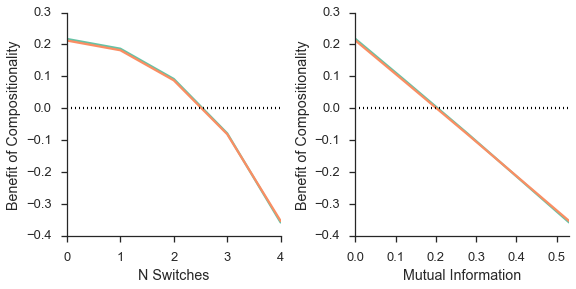

In [26]:
#minimize the alpha for each goal sequence
from scipy.optimize import minimize


N = 10
n_conflict = range(N/2, N)
compositionality_benefit = list()
compositionality_benefit_fa = list()
mutual_information_list = list()

for n in n_conflict:
    
    context_goals = [0] * N + [1] * N 
    context_maps = [0] * (n) + [1] * (N-n) + [1] * n + [0] * (N-n)
    def f0(alpha):
        return crp.evaluate(context_goals, alpha=alpha)
    res0 = minimize(f0, 1.0)
    
    def f1(alpha):
        return crp.evaluate_joint(context_goals, context_maps, alpha=alpha)
    res1 = minimize(f1, 1.0)
    
    mutual_information_list.append(mutual_information(context_goals, context_maps))
    
    compositionality_benefit.append(res1.fun - res0.fun)
    compositionality_benefit_fa.append(f1(1.0) - f0(1.0))
    h_p.append(list_entropy(context_goals))
    

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
axes[0].plot(n_conflict, compositionality_benefit)
axes[0].plot(n_conflict, compositionality_benefit_fa)
axes[0].plot(n_conflict, [0]*len(n_conflict), 'k:')
axes[0].set_ylabel('Benefit of Compositionality')
axes[0].set_xlabel('N Switches')
axes[0].set_xticks(range(5, 10))
axes[0].set_xticklabels('0 1 2 3 4'.split())

axes[1].plot(mutual_information_list, compositionality_benefit)
axes[1].plot(mutual_information_list, compositionality_benefit_fa)

axes[1].plot(mutual_information_list, [0]*len(mutual_information_list), 'k:')
axes[1].set_ylabel('Benefit of Compositionality')
axes[1].set_xlabel('Mutual Information')
axes[1].set_xlim((0, np.max(mutual_information_list)))
plt.subplots_adjust(wspace=0.35)
sns.despine()

model/crp.py:106: RuntimeWarning: invalid value encountered in log2
  goal_guesses -= np.log2(crp_pmf[k])


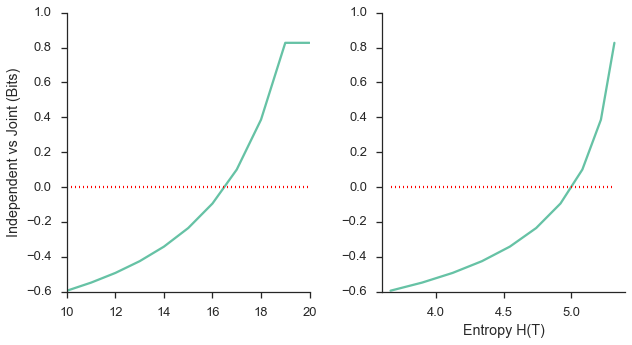

In [27]:
#minimize the alpha for each goal sequence
from scipy.optimize import minimize


N = 20
n_conflict = range(N/2, N)
compositionality_benefit = list()
compositionality_benefit_fa = list()
entropy_map_list = list()
n_list = range(10, 21)
for n in n_list:
    context_goals = ([0] * N + [1]*N)
    context_maps = [0] * (N-n) + (range(1, n+1)) + [n+1] * (N-n) + (range(n+2, 2*(n+1)))

    def f0(alpha):
        return crp.evaluate(context_goals, alpha=alpha)
    res0 = minimize(f0, 1.0)
    
    def f1(alpha):
        return crp.evaluate_joint(context_goals, context_maps, alpha=alpha)
    res1 = minimize(f1, 1.0)
    
    entropy_map_list.append(list_entropy(context_maps))
    
    compositionality_benefit.append(res1.fun - res0.fun)
    compositionality_benefit_fa.append(f1(1.0) - f0(1.0))
    h_p.append(list_entropy(context_goals))
    

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(n_list, compositionality_benefit)
axes[0].plot(n_list, [0]*len(n_list), 'r:')
axes[0].set_ylabel('Independent vs Joint (Bits)')
# axes[0].set_xlabel('Number of Most Popular Goal in Map in list of 10')

axes[1].plot(entropy_map_list, compositionality_benefit)
axes[1].plot(entropy_map_list, [0]*len(entropy_map_list), 'r:')
axes[1].set_xlabel('Entropy H(T)')
plt.subplots_adjust(wspace=0.3)
sns.despine()

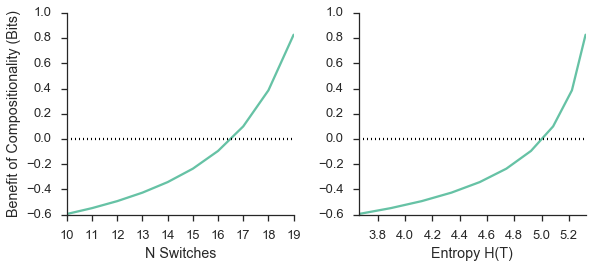

In [28]:
#minimize the alpha for each goal sequence
from scipy.optimize import minimize


N = 20
n_conflict = range(N/2, N)
compositionality_benefit = list()
entropy_map_list = list()
n_list = range(10, 20)

for n in n_list:
    context_goals = ([0] * N + [1]*N)
    context_maps = [0] * (N-n) + (range(1, n+1)) + [n+1] * (N-n) + (range(n+2, 2*(n+1)))

    def f0(alpha):
        return crp.evaluate(context_goals, alpha=alpha)
    res0 = minimize(f0, 1.0)
    
    def f1(alpha):
        return crp.evaluate_joint(context_goals, context_maps, alpha=alpha)
    res1 = minimize(f1, 1.0)
    
    entropy_map_list.append(list_entropy(context_maps))
    
    compositionality_benefit.append(res1.fun - res0.fun)
    h_p.append(list_entropy(context_goals))
    

fig, axes = plt.subplots(1, 2, figsize=(8.5, 4))
axes[0].plot(n_list, compositionality_benefit)
axes[0].plot(n_list, [0]*len(n_list), 'k:')
axes[0].set_ylabel('Benefit of Compositionality (Bits)')
axes[0].set_xlabel('N Switches')
# axes[0].set_xlabel('Number of Most Popular Goal in Map in list of 10')

axes[1].plot(entropy_map_list, compositionality_benefit)
axes[1].plot(entropy_map_list, [0]*len(entropy_map_list), 'k:')
axes[1].set_xlabel('Entropy H(T)')
axes[1].set_xlim(np.min(entropy_map_list), np.max(entropy_map_list))
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
sns.despine()

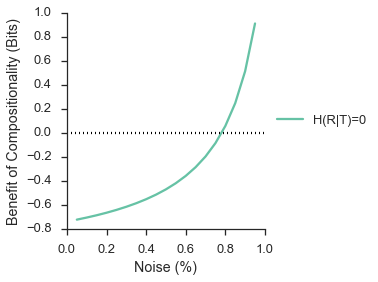

In [29]:
#minimize the alpha for each goal sequence
from scipy.optimize import minimize


N = 20
compositionality_benefit = list()
compositionality_benefit_fa = list()
entropy_map_list = list()
n_list = range(1, N)


for n in n_list:
    context_goals = [0] * N + [1, 2, 3]
    context_maps = [0] * (N-n) + (range(4, n+4)) + [1, 2, 3]

    def f0(alpha):
        return crp.evaluate(context_goals, alpha=alpha)
    res0 = minimize(f0, 0.01)
    
    def f1(alpha):
        return crp.evaluate_joint(context_goals, context_maps, alpha=alpha)
    res1 = minimize(f1, 0.01)
    
    entropy_map_list.append(list_entropy(context_maps))
    compositionality_benefit.append(res1.fun - res0.fun)
    compositionality_benefit_fa.append(f1(1.0) - f0(1.0))
    h_p.append(list_entropy(context_goals))
    

fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))
hand1 = ax.plot(np.array(n_list, dtype=float)/N, compositionality_benefit, label='H(R|T)=0')
ax.plot([0, 1],[0, 0], 'k:')
ax.set_ylabel('Benefit of Compositionality (Bits)')
ax.set_xlabel('Noise (%)')

ax.set_position([0.2,0.15,0.5,0.75])
plt.legend(loc='center left', bbox_to_anchor = (1.0, 0.5))
sns.despine()

/Users/nickfranklin/anaconda/lib/python2.7/site-packages/scipy/optimize/optimize.py:895: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


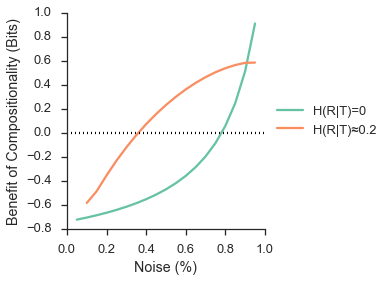

In [30]:
#minimize the alpha for each goal sequence
from scipy.optimize import minimize


N = 20
compositionality_benefit_2 = list()
entropy_map_list = list()
n_list = range(1, N)


for n in n_list:
    context_goals = [0] * N + [1, 2, 3, 1, 2, 3]
    context_maps = [0] * (N-n) + (range(4, n+4)) + [1, 2, 3, 2, 3, 1]

    def f0(alpha):
        return crp.evaluate(context_goals, alpha=alpha)
    res0 = minimize(f0, 0.01)
    
    def f1(alpha):
        return crp.evaluate_joint(context_goals, context_maps, alpha=alpha)
    res1 = minimize(f1, 0.01)
    
    entropy_map_list.append(list_entropy(context_maps))
    compositionality_benefit_2.append(res1.fun - res0.fun)
    h_p.append(list_entropy(context_goals))
    

fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))
hand1 = ax.plot(np.array(n_list, dtype=float)/N, compositionality_benefit, label='H(R|T)=0')
hand2 = ax.plot(np.array(n_list, dtype=float)/N, compositionality_benefit_2, label=u'H(R|T)≈0.2')
ax.plot([0, 1],[0, 0], 'k:')
ax.set_ylabel('Benefit of Compositionality (Bits)')
ax.set_xlabel('Noise (%)')

ax.set_position([0.2,0.15,0.5,0.75])
plt.legend(loc='center left', bbox_to_anchor = (1.0, 0.5))
sns.despine()

# Appendix: Derivation of the CRP bias
CRP:
$$q(k) =\Pr\left (c_{t+1} = k| c_{1:t} \right ) = 
\begin{cases} 
N_k/A & \quad \text{if } k < K_t \\
\alpha/A & \quad \text{if } k_K+1 \\
\end{cases}
$$

bias for $k \in K$:

$\begin{align}
\text{Bias}_{p_k}[q_k] 
    &= \mathbb{E}\left [\frac{N_k}{\alpha + N_c}\right ] - p_k \\
    \\
    &= \frac{p_k N_c}{\alpha + N_c} - \frac{p_k(\alpha + N_c)}{\alpha + N_c} \\
    \\
    &= p_k\frac{-\alpha}{\alpha + N_c}\\
\end{align}
$ 



$\\\text{Bias}_p[q] = \sum_{k\in K} \text{Bias}_p[q] = \sum_{k\in K}p_k\frac{-\alpha}{\alpha + N_c} = \frac{-\alpha}{\alpha + N_c}$



# Appendix: Exchangablitiy
The CRP is exchangable, meaning the process in invariant to permutation. As such the ordering of the sequence doesn't matter, and won't effect our overall measure of evaluations. This is easy enough to show:

In [31]:
X = [0, 0, 0, 0, 1, 2, 3, 4]
print "CRP Entropy:", crp.evaluate(X, max_goals=5)

CRP Entropy: 2.97877983227


In [32]:
X = np.random.permutation(X)
print X
print "CRP Entropy:", crp.evaluate(X, max_goals=5)

[3 0 0 0 2 1 4 0]
CRP Entropy: 2.97877983227
